In [192]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

We want to do Bayesian linear regression on some height-weight data. Let the data be pairs $\left\{\left(x,y\right)\right\}$ where $x$ and $y$ are a subject's weight and height, respectively. We want to model height as a function of weight.

The standard linear regression model, with priors of our choice, is
\begin{align} 
    y & \sim \mathcal{N}\left(\mu, \sigma^2\right) \\
    \mu & = \alpha + \beta x \\
    \sigma^2 & \sim \mathcal{U}\left[0,15\right] \\
    \alpha & \sim \mathcal{N}\left(10, 10\right) \\
    \beta & \sim \mathcal{N}\left(50, 10\right) \\
\end{align}

How to interpret this?
* `y` is the actual observed height, and we assume it's drawn from a normal distribution with mean $\mu$ and variance $\sigma^2$.
* The mean $\mu$ is a linear function of the weight, $x$. This is how $x$ influences $y$; namely, $$ \text{Pr}\left(y \, \middle| \, x, \alpha, \beta, \sigma^2 \right) = \mathcal{N}\left(y; \; \alpha + \beta x, \, \sigma^2\right) $$ is the data likelihood!
* The model parameters are $\sigma^2$, $\alpha$, and $\beta$, each with their own prior. These combine to form the prior distribution: $$ \text{Pr}\left(\sigma^2, \alpha, \beta\right) = \text{Pr}\left(\sigma^2\right) \text{Pr}\left(\alpha\right) \text{Pr}\left(\beta\right) $$

\begin{align}
    \text{Pr}\left(x,y,\alpha,\beta,\sigma^2\right) & = \text{Pr}\left( y \, \middle| \, x,\alpha,\beta,\sigma^2\right)\text{Pr}\left(x,\alpha,\beta,\sigma^2\right) \\
     & = \text{Pr}\left( y \, \middle| \, x,\alpha,\beta,\sigma^2\right)\text{Pr}\left(x \, \middle| \, \alpha,\beta,\sigma^2 \right)\text{Pr}\left(\alpha,\beta,\sigma^2\right) \\
     & = \text{Pr}\left( y \, \middle| \, x,\alpha,\beta,\sigma^2\right)\text{Pr}\left(x\right)\text{Pr}\left(\alpha\right)\text{Pr}\left(\beta\right)\text{Pr}\left(\sigma^2\right) \\
\end{align}

where in the last line we used our modeling assumption that the weights $x$ are independent of the model parameters. In fact, we aren't interested in modeling $x$ at all in our model, so we will ignore the prior term $\text{Pr}\left(x\right)$ entirely (this is a natural consequence of how we use Bayes' rule).

Our goal is the posterior distribution of the parameters given the data: $$ \text{Pr}\left(\alpha, \beta, \sigma^2 \, \middle| \, \mathcal{D}\right).$$ We can get a handle on this by applying Bayes' rule:
\begin{align} 
    \text{Pr}\left(\alpha, \beta, \sigma^2 \, \middle| \, \mathcal{D}\right) & \propto \text{Pr}\left(\mathcal{D},\alpha,\beta,\sigma^2 \right) \\
    & = \prod_{i=1}^N \text{Pr}\left(x^{\left(i\right)}, y^{\left(i\right)}\,\middle|\,\alpha,\beta,\sigma^2\right) \text{Pr}\left(\alpha,\beta,\sigma^2\right) \\
\end{align}
where we use the assumption that observations are independent and identically distributed (i.i.d.).

Last, we will apply all of these assumptions to write out the posterior in full:

\begin{align} 
    \text{Pr}\left(\alpha, \beta, \sigma^2 \, \middle| \, \mathcal{D}\right) & = \prod_{i=1}^N \text{Pr}\left(y^{\left(i\right)}\,\middle|\,x^{\left(i\right)},\alpha,\beta,\sigma^2\right) \text{Pr}\left(x^{\left(i\right)} \, \middle| \, \alpha,\beta,\sigma^2\right)\text{Pr}\left(\alpha,\beta,\sigma^2\right) \\
    & = \prod_{i=1}^N \text{Pr}\left(y^{\left(i\right)}\,\middle|\,x^{\left(i\right)},\alpha,\beta,\sigma^2\right) \text{Pr}\left(x^{\left(i\right)}\right)\text{Pr}\left(\alpha,\beta,\sigma^2\right) \\
    & \propto \prod_{i=1}^N \text{Pr}\left(y^{\left(i\right)}\,\middle|\,x^{\left(i\right)},\alpha,\beta,\sigma^2\right)\text{Pr}\left(\alpha,\beta,\sigma^2\right) \\
    & \propto \text{Pr}\left(\alpha,\beta,\sigma^2\right) \prod_{i=1}^N \text{Pr}\left(y^{\left(i\right)}\,\middle|\,x^{\left(i\right)},\alpha,\beta,\sigma^2\right)\\
\end{align}

where in the second-to-last line we used proportionality to ignore the $x^{\left(i\right)}$ factors, and in the last line we pulled the prior distribution out of the product. Note that the product is the data likelihood still, but written as a product of the likelihoods of each observed data point.

What we have done is written the posterior distribution over the parameters given the data as (proportional to) the prior multiplied by the likelihood --- this is the standard Bayesian modeling program. We earlier described the assumed functional form of these distributions: uniform and normal, respectively. We are ready to use MCMC to perform Bayesian inference, i.e., to construct this posterior distribution.

### Generate some data for our problem

To get some data to work with, I will pick some "true" values for the parameters and generate data using our model. In reality, the model is only an approximation of how we think the world works (the data-generating process); for this toy example, the model will be exact.

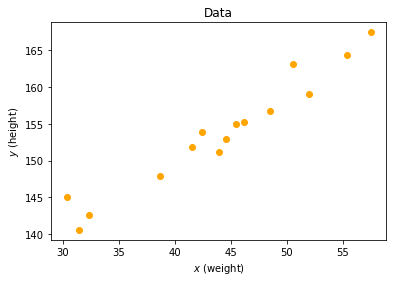

In [193]:
# true data-generating parameters (unknown, AKA "latent")
# these are what we want to learn from the data
alpha_true = 113.90
beta_true = 0.90
sigma_true = 3.07

n_data = 15
x_i = np.random.uniform(30.0, 60.0, size=n_data)
mu_f = lambda t: alpha_true + beta_true * t
y_i = np.random.normal(loc=mu_f(x_i), scale=sigma_true)
D = np.stack([x_i, y_i], axis=1)

fig, ax = plt.subplots()
ax.scatter(x_i, y_i, marker='o', color='orange')
ax.set(
    title='Data',
    xlabel=r'$x$ (weight)',
    ylabel=r'$y$ (height)',
);


### Define the Model

Assume we have this data `D`. Let's define our `pmyc3.Model`:
\begin{align} 
    y & \sim \mathcal{N}\left(\mu, \sigma^2\right) \\
    \mu & = \alpha + \beta x \\
    \sigma^2 & \sim \mathcal{U}\left[0,15\right] \\
    \alpha & \sim \mathcal{N}\left(10, 10\right) \\
    \beta & \sim \mathcal{N}\left(50, 10\right) \\
\end{align}

In [200]:
with pm.Model() as bayes_linreg_model:
    # priors
    alpha = pm.Normal('alpha', mu=150, sigma=15)
    beta = pm.Normal('beta', mu=5, sigma=15)
    sigma = pm.Uniform('sigma', lower=0, upper=25)

    # mu_i = pm.Deterministic('mu_i', alpha + beta * D[:,0].T)

    # likelihood
    y_i = pm.Normal('y_i', mu=alpha + beta * D[:,0], sigma=sigma, observed=D[:,1])

### Check the model: prior predictive checks

We can check how "good" our choice of priors is by randomly sampling from the priors. Each sample is a sample of parameter values, which themselves define a line. If these lines "look plausible" when compared to the data, we can be confident that we chose our priors well :)

In [201]:
# take samples from the prior distribution over parameters
with bayes_linreg_model:
    prior_checks = pm.sample_prior_predictive(samples=50)
prior_checks.keys()

dict_keys(['sigma_interval__', 'sigma', 'alpha', 'beta', 'y_i'])

Each sample here is a sample from our model --- so a tuple $\left(\sigma, \alpha,\beta,y\right)$ --- *before* the model has "seen" any data; we are drawing a value of parameters from the priors, and then an observation from the likelihood, using that draw from the priors. Ignoring the generated observations, let's see what the lines generated from the priors look like, compared with the data.

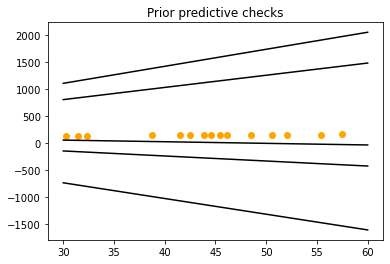

In [202]:
fig, ax = plt.subplots()

ax.scatter(D[:,0], D[:,1], marker='o', color='orange')
t = np.array([30, 60])

alpha_prior_pred = prior_checks['alpha']
beta_prior_pred = prior_checks['beta']
sigma_prior_pred = prior_checks['sigma']

for i in range(5):
    ax.plot(t, alpha_prior_pred[i] + beta_prior_pred[i] * t, color='black', ls='-')
ax.set(title='Prior predictive checks');

The lines drawn from the posterior look like they're about right, but we could probably tune some of the priors to make them closer. (there's may be something philosophically wrong with tuning the priors like this, but I don't want to think about it)

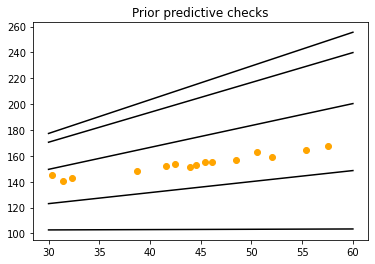

In [203]:
# redefine the model with adjusted priors
with pm.Model() as bayes_linreg_model:
    # priors
    alpha = pm.Normal('alpha', mu=100, sigma=2)
    beta = pm.Normal('beta', mu=.8, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    # mu_i = pm.Deterministic('mu_i', alpha + beta * D[:,0].T)

    # likelihood
    y_i = pm.Normal('y_i', mu=alpha + beta * D[:,0], sigma=sigma, observed=D[:,1])


# take samples from the prior distribution over parameters
with bayes_linreg_model:
    prior_checks = pm.sample_prior_predictive(samples=50)
prior_checks.keys()

fig, ax = plt.subplots()

ax.scatter(D[:,0], D[:,1], marker='o', color='orange')
t = np.array([30, 60])

alpha_prior_pred = prior_checks['alpha']
beta_prior_pred = prior_checks['beta']
sigma_prior_pred = prior_checks['sigma']

for i in range(5):
    ax.plot(t, alpha_prior_pred[i] + beta_prior_pred[i] * t, color='black', ls='-')
ax.set(title='Prior predictive checks');

Those look a little better; they're at least touching the data now and the range of the $y$ axis is shrunken significantly.

Remember, the prior distributions are just a starting point. The actual posterior is a combination of the prior with the data.

### Perform inference: MCMC

Now that we looked at what the priors are predicting for the model parameters, we can factor in the data and thus obtain the posterior distribution over the model parameters. We compute the posterior by means of MCMC, where the posterior we obtain will be represented by a bunch of samples.

For completeness, I'll re-define the model here once again.

In [204]:
with pm.Model() as bayes_linreg_model:
    # priors
    alpha = pm.Normal('alpha', mu=100, sigma=2)
    beta = pm.Normal('beta', mu=.8, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    # likelihood
    y_i = pm.Normal('y_i', mu=alpha + beta * D[:,0], sigma=sigma, observed=D[:,1])

    # actually perform sampling
    trace = pm.sample(draws=1200, tune=1200, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_200 tune and 1_200 draw iterations (2_400 + 2_400 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


We will use the package `arviz` (usually bundled with `pymc3`) for visualizing the MCMC random walk through parameter space.

The random walk through parameter space generates a sequence of samples $\left(\alpha_j, \beta_j, \sigma_j\right)$, and this sequence is called the "trace". Each MCMC run is comprised of a number of "chains" (Markov chains), each of which is a random walk that generates its own trace.

In the output of the above cell's sampling, you can see it defaulted to "Sampling 2 chains." Below we can plot the trace.

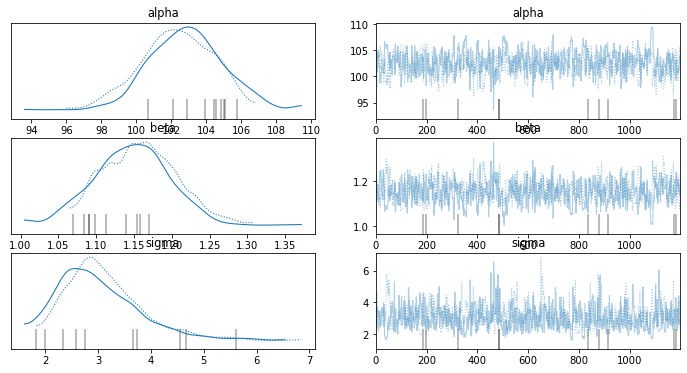

In [205]:
import arviz as az

with bayes_linreg_model:
    az.plot_trace(trace)

The right column shows the samples obtained in each trace for each of the parameters (remember that $\alpha$,$\beta$, and $\sigma$ are sampled jointly!). So the $x$-axis is step number and the $y$-axis is the value of the parameter obtained on that sample step. It's hard to see, but there are actually two traces in each panel --- one solid and one dashed --- one for each chain.

The left column panels are obtained by taking the histogram of the values obtained in the corresponding right column panel. These are histograms of the $y$-values. The more "stable" the trace is, in that it walks around a small set of values, the more sharply-peaked the histogram will be.

In any case, the plots on the left are the posterior distribution over the model parameters! More precisely, they're slices of the actual posterior distribution, which is itself a distribution over 3-space, and impossible to visualize nicely.

Recall what these posteriors represent: they encode our belief in *plausible values* for the various model parameters based on (1) the priors we started with and (2) the data we have observed.

Notice that the posteriors of $\alpha$ and $\beta$ look nearly normal; that is somewhat expected because our prior over these were normal distributions! 

The posterior over $\sigma$ is similarly unimodal. But our prior over $\sigma$ was a uniform distribution! This is an example of how --- via MCMC inference --- the data has "warped" the prior distribution to incorporate the knowledge we gained from the data.

### What now?

Traditionally in ML, we would take a point estimate of the parameters and use this point estimate to make predictions on new inputs. One very popular way to do that in the Bayesian framework is to take the *maximum a posteriori* , or MAP, estimate, which is the set of parameters $\left(\alpha_{\text{MAP}}, \beta_{\text{MAP}}, \sigma_{\text{MAP}}\right)$ which maximize the posterior.

In fact, MAP estimation can be done even without doing the MCMC simulations (taking all the samples) and constructing the posterior distribution! `pymc3` provides some handy functions for doing this:

In [206]:
map_estimate = pm.find_MAP(model=bayes_linreg_model)
map_estimate

{'alpha': array(103.00587832),
 'beta': array(1.1447299),
 'sigma_interval__': array(-1.02869136),
 'sigma': array(2.63337889)}

Note sure exactly how this works, but I see something like "`grad`" in the output there so I assume it's some sort of descent-based optimization algorithm.

It looks like it's finding the MAP estimate to be about where the peaks of the posteriors are in the above trace plots, which validates that our posterior sampling (the MCMC) worked correctly.

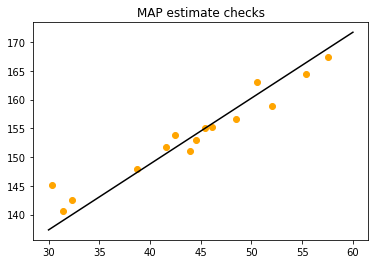

In [207]:
fig, ax = plt.subplots()

ax.scatter(D[:,0], D[:,1], marker='o', color='orange')
t = np.array([30, 60])

alpha_MAP = map_estimate['alpha']
beta_MAP = map_estimate['beta']
sigma_MAP = map_estimate['sigma']


ax.plot(t, alpha_MAP + beta_MAP * t, color='black', ls='-')
ax.set(title='MAP estimate checks');

This looks pretty good!

Of course, we could try other point estimates, e.g., the mean of the posterior.


Here's the big drawback: the MCMC approach generated a (posterior) distribution of plausible parameter values, not just a single point estimate. By using the MAP point estimate, we are effectively tossing out all of the informating that the posterior distribution gives us about the parameter values, including, for example, the spread of that distribution. The variance of the posterior gives us information about how confident we are in the possible parameter values.

There's a notion of using cost functions and optimization under uncertainty to choose a parameter point estimate, using the posterior distribution, so that your expected cost is minimized. This of course depends on a cost function, and is generally application-dependent. But it shows how powerful it is that we are really obtaining not just a single value but a range of possible values for the parameters.

### Posterior predictive checks

We can actually do better. Since the posterior distribution is a distribution over parameter values, we can draw from the posterior. A draw from the posterior is a tuple $\left(\alpha,\beta,\sigma\right)$, and since the posterior distributions is weighted toward "likely" values of the parameters, when we draw from this distribution, we get parameter tuples which are "plausible." 

In this linear regression example, each draw from the posterior corresponds to a linear model, which we can plot. Let's take a bunch of samples from the posterior distribution, then plot the linear models (lines) which arise:

In [208]:
with bayes_linreg_model:
    # pymc3 function for easily sampling from the posterior/trace
    posterior_checks = pm.sample_posterior_predictive(
        trace, var_names=["alpha", "beta", "sigma"]
    )

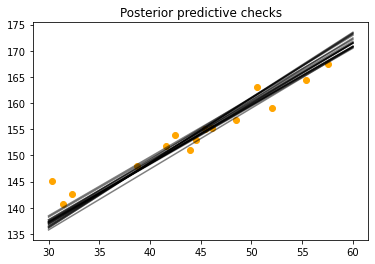

In [209]:
fig, ax = plt.subplots()

ax.scatter(D[:,0], D[:,1], marker='o', color='orange')
t = np.array([30, 60])

alpha_post_pred = posterior_checks['alpha']
beta_post_pred = posterior_checks['beta']
sigma_post_pred = posterior_checks['sigma']

for i in range(20):
    ax.plot(t, alpha_post_pred[i] + beta_post_pred[i] * t, color='black', ls='-', alpha=0.5)
ax.set(title='Posterior predictive checks');

Compare this with the prior predictive checks; now, our plausible values of the parameters (the posterior) gives us parameter values --- and thus linear models --- which better fit the data!

To make this truly a posterior **predictive** distribution, we can generate predictions from each of the parameters (lines) we drew from the posterior distribution. The flow is:
1. Draw a bunch of parameter tuples from the posterior distribution.
2. For each $x$ in the domain (at least a discrete set of these):
    
    a. Draw $y \sim \text{Pr}\left(y \, \middle| \, x, \alpha, \beta, \sigma\right)$ from the likelihood, for each parameter draw. This is a set of predictions for that particular value of $x$.

Below, we won't actually plot a bunch of generated predictions for each value of $x$, but we can summarize by plotting the mean and the spread of the predictions, for each $x$. This gives us an idea of **how the uncertainty in the parameter estimates (the posterior) propagates to uncertainty in predictions**.

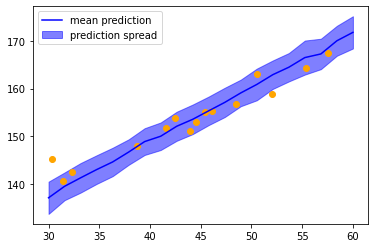

In [210]:

n_x = 20
x = np.linspace(30.0, 60.0, num=n_x)
y_mean = np.zeros_like(x)
y_std = np.zeros_like(x)


i=100
alpha_i = posterior_checks['alpha'][:i]
beta_i = posterior_checks['beta'][:i]
sigma_i = posterior_checks['sigma'][:i]

for j in range(n_x):
    y_pp = np.random.normal(loc=alpha_i + beta_i * x[j], scale=sigma_i)
    y_mean[j] = y_pp.mean()
    y_std[j] = y_pp.std()

fig, ax = plt.subplots()
ax.plot(x, y_mean, color='blue', label='mean prediction')
ax.fill_between(x, y_mean + y_std, y_mean - y_std, color='blue', alpha=0.5, label='prediction spread')
ax.legend()
ax.scatter(D[:,0], D[:,1], color='orange', label='original data');